# Prerequisites
You have at least a moderate understanding of Python, more specifically Python-3.

You have installed TerminusDB,  and at a minimum taken a quick look at the prior tutorial (number 1).

You have the TerminusDB console running,  at `http://localhost:6363/console`.



## Check your installation
Check that the following `import` list does not generate any Python errors:


In [49]:
import pandas as pd
import woqlclient.woqlClient as woql
from woqlclient import WOQLQuery
import woqlclient.errors as woqlError
import woqlclient.woqlDataframe as wdf

# Using .csv file

The first tutorial showed how to load data into TerminusDB from in-memory Python structures.

In this tutorial, we look at how to use an .csv file for the raw data.  There are in fact several steps to loading a .csv file into TerminusDB:
* Loading the raw .csv file into memory (locally, or over the internet)
* Generating TerminusDB documents (typically, one per row of your .csv file)
* Initialising the properties of each new document
* Finally, inserting the new documents into TerminusDB

Sometimes you may wish to do consistency checks and clean up the raw data from the .csv file. This can of course be done directly in Python, but you also can use TerminusDB to help identify inconsistent raw data and clean it up. 

----

## The sample .csv file used in this tutorial
For the data in this tutorial, we'll use a simple example of people and couples.  Each person has a first name, an age, and possibly a partner. Nobody should have more than one partner. And if somebody claims to be the partner of somebody else,  then that other person should confirm that they are indeed the partner.

The raw data in the .csv file consists of an initial row of column names; followed by the actual data.  Each row is an index number, a name, age and partner name:

Note that in this raw data, neither Dave nor Sue have a partner.  Also note that Joe and Jim both claim to be Kris's partner,  but Kris asserts Jim is the chosen one, rather than Joe.

----

## Creating the database and the schema
As a first step, we'll create a new and empty database,  and a schema.

The schema is simple, and matches the .csv file:  each person has a first name, an age, and possibly a partner. 

Let's create the database,  and build a simple schema.  Following the approach from the first tutorial:

In [50]:
import sys
import os

server_url    = "http://localhost:6363"
key           = "root"
dBId          = "DB_CSV"

class suppress_Terminus_diagnostics:

    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        
client = woql.WOQLClient()
print("[Connecting to the TerminusDB server..]")
with suppress_Terminus_diagnostics():
    client.connect(server_url, key)
    
try:
    print("[Removing prior version of database '{}',  if it exists..]".format(dBId))
    with suppress_Terminus_diagnostics():
        client.deleteDatabase(dBId)
except Exception as e:
    print("[No prior database to delete]")
    
print("[Creating database '{}']".format(dBId))
with suppress_Terminus_diagnostics():
    client.createDatabase(dBId, "My second database")
    
schema = WOQLQuery().when(
                        True,
                        WOQLQuery().doctype("PersonType").label("Person").\
                        description("An individual"). \
                        property("Age", "integer").label("years").\
                        property("Partner", "string").label("partner_first_name")
)


print("[Building schema..]")
with suppress_Terminus_diagnostics():
    schema.execute(client)

[Connecting to the TerminusDB server..]
[Removing prior version of database 'DB_CSV',  if it exists..]
[Creating database 'DB_CSV']
[Building schema..]


----

## Loading the .csv file
When you load a .csv file,  you must tell WOQL what is the relationship between the column names in your .csv,  and the documents and their various properties in your schema.  This is done with WOQL `get` and `woql_as`. The `get` retrieves the raw data. Each `woql_as` establishes the correspondance between a .csv column name and a WOQL variable:

In [51]:
wq = WOQLQuery().get(
        WOQLQuery().woql_as("Nr", "v:Nr").
            woql_as("Name", "v:Name").
            woql_as("Age", "v:Age").
            woql_as("Partner", "v:Partner")
    )

Note that each of the first parameters of the `woql_as` clauses are column names in the .csv file.

Of course, this has simply made a WOQL query object: it has not yet actually executed it.

To execute it, we must give the location of the .csv file: either a local file, or a resource on the internet.  Unfortunately however the `woqlclient` module has a different call for each case (it would be perhaps nicer if there was a single call which would work out which of the two cases applies -- but see later below!).

### Using a .csv file across the internet
If you have the URL to your .csv file,  you can use the WOQL `remote` method to set up a query to read and process it, and then go ahead and execute the query:

In [52]:
csv = wq.remote("https://raw.githubusercontent.com/Chrisjhorn/terminusDB/master/tutorials/tutorial2/people.csv")
result = csv.execute(client)

Sending to URL____________ http://localhost:6363/DB_CSV/woql
sendRequestByAction_____________ woql_update


The result of the `execute` is WOQL bindings established by your various `woql_as` calls. It may be useful to examine the result and confirm that things look good, so far:

In [53]:
df = wdf.query_to_df(result)
print(df.to_string(index=False))

  Age   Name    Nr Partner
 34.0   John   0.0   Marie
 26.0   Anne   1.0   Peter
 28.0   Mike   2.0   Jenny
 27.0  Peter   3.0    Anne
 27.0  Jenny   4.0    Mike
 33.0  Marie   5.0    John
 34.0    Joe   6.0    Kris
 35.0   Kris   7.0     Jim
 36.0    Jim   8.0    Kris
 34.0   Dave   9.0        
 26.0    Sue  10.0        


Note that the columns of the dataframe are built in alphabetical order by `query_to_df`,  but that otherwise the dataframe reflects the contents of the raw .csv file.

### Using a local .csv file
Alternatively, you can load a local file using the WOQL `file` method.

However, things are slightly complicated because your local TerminusDB server is running inside a [docker container](https://hub.docker.com/).  Docker has to be told what part of your local file system it can access.  And then you must give the path to your local .csv file relative to that.

There's a good [medium.com article](https://medium.com/terminusdb/loading-your-local-files-in-terminusdb-e0b5dfbe59b4) by Cheuk of the core team about how to do this -- in fact there is a *bunch* of articles about TerminusDB by various members of the team on [medium.com](https://medium.com/search?q=terminusdb),  including the original motivation for TerminusDB and how it came to be.  Well worth a read when you have a few minutes..

Anyway. To use a local file you must first stop your TerminusDB server;  then set up the (operating system) environment variable `TERMINUS_LOCAL` to whatever part of your file system you are willing to let docker and your TerminusDB server access; and then restart your server.  Assuming that you are in the `terminus-quickstart` folder in the standard distribution of TerminusDB,  you need to do:

After restarting the server,  docker and the TerminusDB server should give you a message like:

OK, now we can get back to Python. Rather than using `remote` and a URL, we now use `file` and give it the pathname to the local .csv file but with the path prefix `/app/local_files/`.  And take a quick look at the `result` to ensure all looks good:

In [54]:
csv = wq.file("/app/local_files/people.csv")
result = csv.execute(client)
df = wdf.query_to_df(result)
print(df.to_string(index=False))

Sending to URL____________ http://localhost:6363/DB_CSV/woql
sendRequestByAction_____________ woql_update
  Age   Name    Nr Partner
 34.0   John   0.0   Marie
 26.0   Anne   1.0   Peter
 28.0   Mike   2.0   Jenny
 27.0  Peter   3.0    Anne
 27.0  Jenny   4.0    Mike
 33.0  Marie   5.0    John
 34.0    Joe   6.0    Kris
 35.0   Kris   7.0     Jim
 36.0    Jim   8.0    Kris
 34.0   Dave   9.0        
 26.0    Sue  10.0        


### Hiding `remote` versus `file`
As an aside, I find the fact that there are two different methods to handle local and remote .csv files a little irritating. I now use a Python helper function to clean things up:

In [55]:
def apply_query_to_url(woqlGet, url):
    '''
        Use either a local file or remote http resource,  to execute a woql get query.
        In the case of a local file,  it should be the file path relative to the value of the
        TERMINUS_LOCAL environment variable set when the TerminusDB server was started...

        :param woqlGet:         a woql get query
        :param url:             string,  eiher a local file name or http-style url
        :return:                return value from executing the woql get
    '''
    if url.startswith("http"):
        return woqlGet.remote(url)
    if not url.startswith("/app/local_files/"):
        url = "/app/local_files/" + url
    return woqlGet.file(url)

You may find perhaps find this helpful. You can pass a URL or local file name as the second parameter, so eg:

Note too that `apply_query_to_url` prepends the `/app/local_files/` if it is needed, just for convenience.

---

# Generating TerminusDB documents
Ok, so far we have just asked the TerminusDB server to load our .csv file,  and we've checked that it did so correctly by looking at the result of query. But on the console window (at `http://localhost:6363/console`), if you click through the `DB_CSV` database and look at the `Documents`,  its clear that nothing yet has been inserted into the database: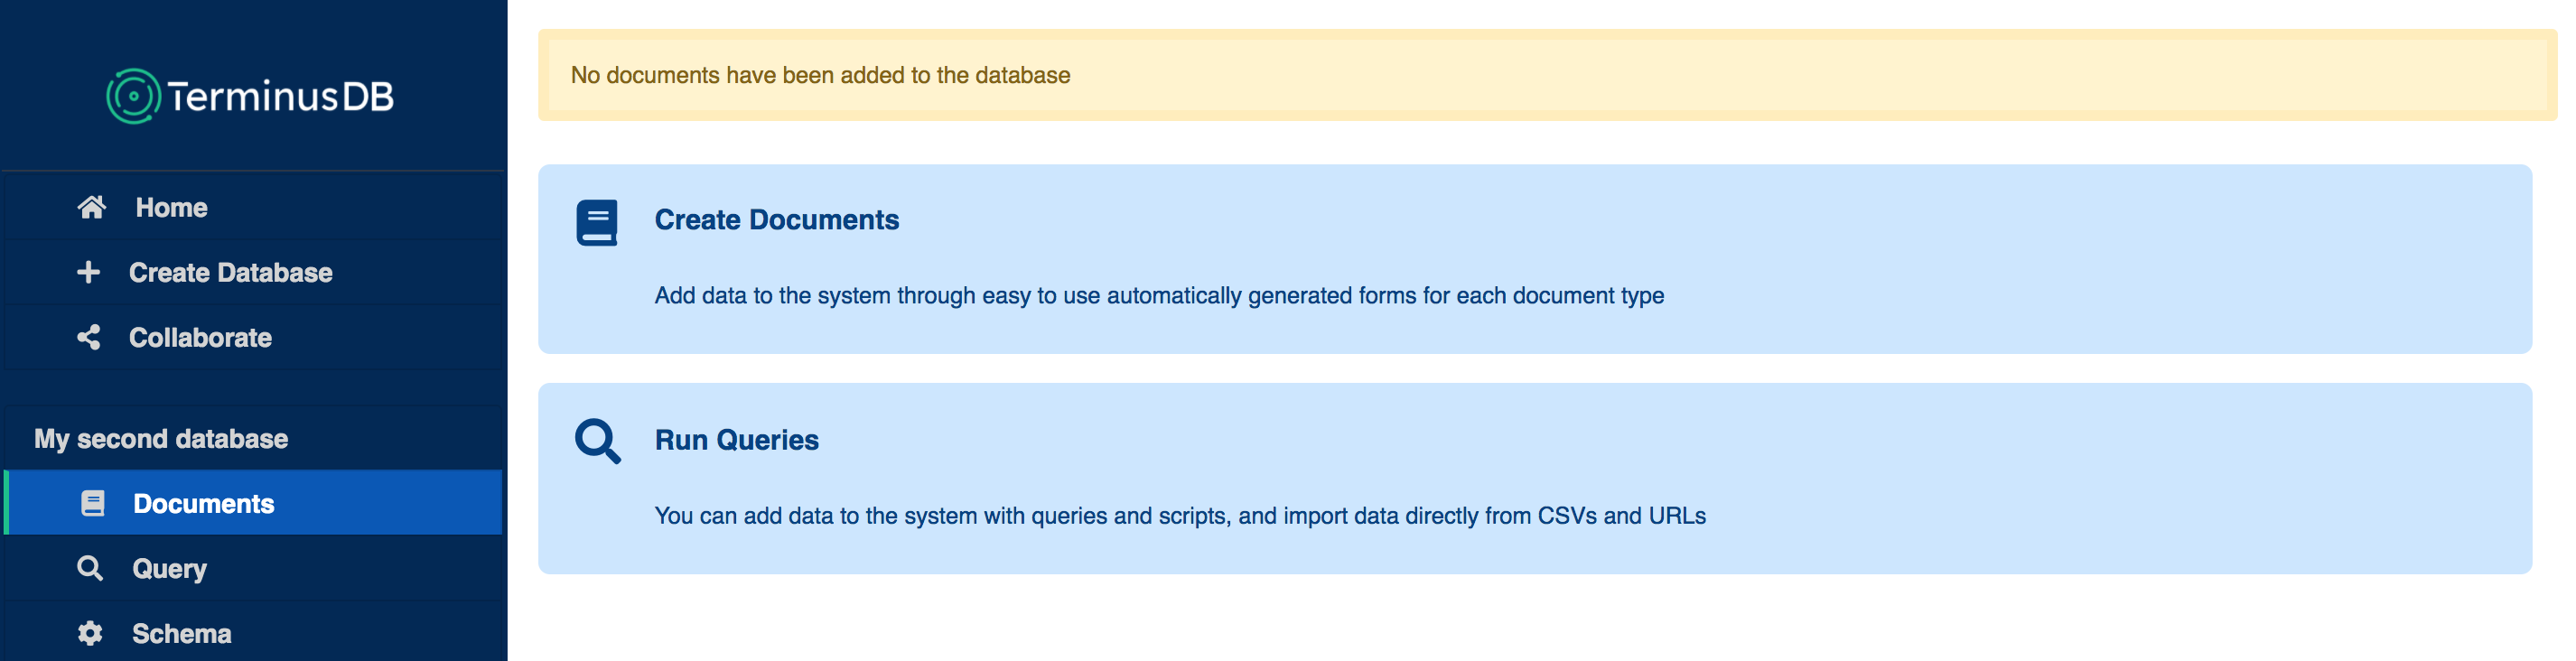

The next step is to create a TerminusDB document (in our schema, we introduced `PersonType` documents) for each person (each row) of our .csv file.  As usual (and as per the first tutorial), `idgen` is used and we can conveniently use the index number of each row in the .csv file, which we woql_as'ed into `v:Nr`, as the `idgen` key:

In [56]:
wrangle = WOQLQuery().idgen("doc:PersonType", ["v:Nr"], "v:People_ID")

Of course, we have not yet executed this in the server, so putting it together with `csv` fetch query which we had in our previous step, into a `woql_and`:

In [57]:
inputs = WOQLQuery().woql_and(csv, wrangle)
result = inputs.execute(client)

Sending to URL____________ http://localhost:6363/DB_CSV/woql
sendRequestByAction_____________ woql_update


Now if we look at the result, the TerminusB URLs for each document have also been created:

In [58]:
df = wdf.query_to_df(result)
print(df.to_string(index=False))

  Age   Name    Nr Partner                                           People_ID
 34.0   John   0.0   Marie   http://localhost:6363/DB_CSV/document/PersonType0
 26.0   Anne   1.0   Peter   http://localhost:6363/DB_CSV/document/PersonType1
 28.0   Mike   2.0   Jenny   http://localhost:6363/DB_CSV/document/PersonType2
 27.0  Peter   3.0    Anne   http://localhost:6363/DB_CSV/document/PersonType3
 27.0  Jenny   4.0    Mike   http://localhost:6363/DB_CSV/document/PersonType4
 33.0  Marie   5.0    John   http://localhost:6363/DB_CSV/document/PersonType5
 34.0    Joe   6.0    Kris   http://localhost:6363/DB_CSV/document/PersonType6
 35.0   Kris   7.0     Jim   http://localhost:6363/DB_CSV/document/PersonType7
 36.0    Jim   8.0    Kris   http://localhost:6363/DB_CSV/document/PersonType8
 34.0   Dave   9.0           http://localhost:6363/DB_CSV/document/PersonType9
 26.0    Sue  10.0          http://localhost:6363/DB_CSV/document/PersonType10


If you look again at the `DB_CSV` entry in the console window, and click the `Documents` button, again the new documents have yet to be actually inserted into the database.  But they're not yet ready to go in: we still have to add the `Age, Name` and `Partner` properties..


---
# Initialising the properties of each new document
As we did in the first tutorial, the next step after `idgen` is to `insert` any properties.  Using the WOQL variables we built from the `woql_as` clauses when we read the .csv file, this becomes straight-forward:

In [59]:
inserts = WOQLQuery().insert("v:People_ID", "PersonType").label("v:Name").\
                    property("Age", "v:Age").\
                    property("Partner", "v:Partner")

Note that the `v:Name` is being used as the `label`.  Alternatively we could dispense with the `label` and introduce the name as a separate property in our schema.

We can try and execute the `inserts` in conjunction with the `idgen` and `csv` fetch, to see what happens:

In [60]:
inputs = WOQLQuery().woql_and(csv, wrangle, inserts)
result = inputs.execute(client) 

Sending to URL____________ http://localhost:6363/DB_CSV/woql
sendRequestByAction_____________ woql_update


However if you look at your console, you will see that the new documents were *not* inserted.

To update the database we of course need to use a `when` clause. The `inserts` above did nothing because there was no associated `when` clause.  So, read on...

---
# Inserting the new documents into TerminusDB
As usual, a WOQL `when` clause takes a condition which if `True`,  then updates the database.  In our case, the condition is that the csv fetch and associated wrangle worked;  and then the insertions can go ahead:

In [61]:
inputs = WOQLQuery().woql_and(csv, wrangle)
update = WOQLQuery().when(inputs, inserts)
result = update.execute(client)

Sending to URL____________ http://localhost:6363/DB_CSV/woql
sendRequestByAction_____________ woql_update


Checking the result in the console window, in the document list for the `DB_CSV` database: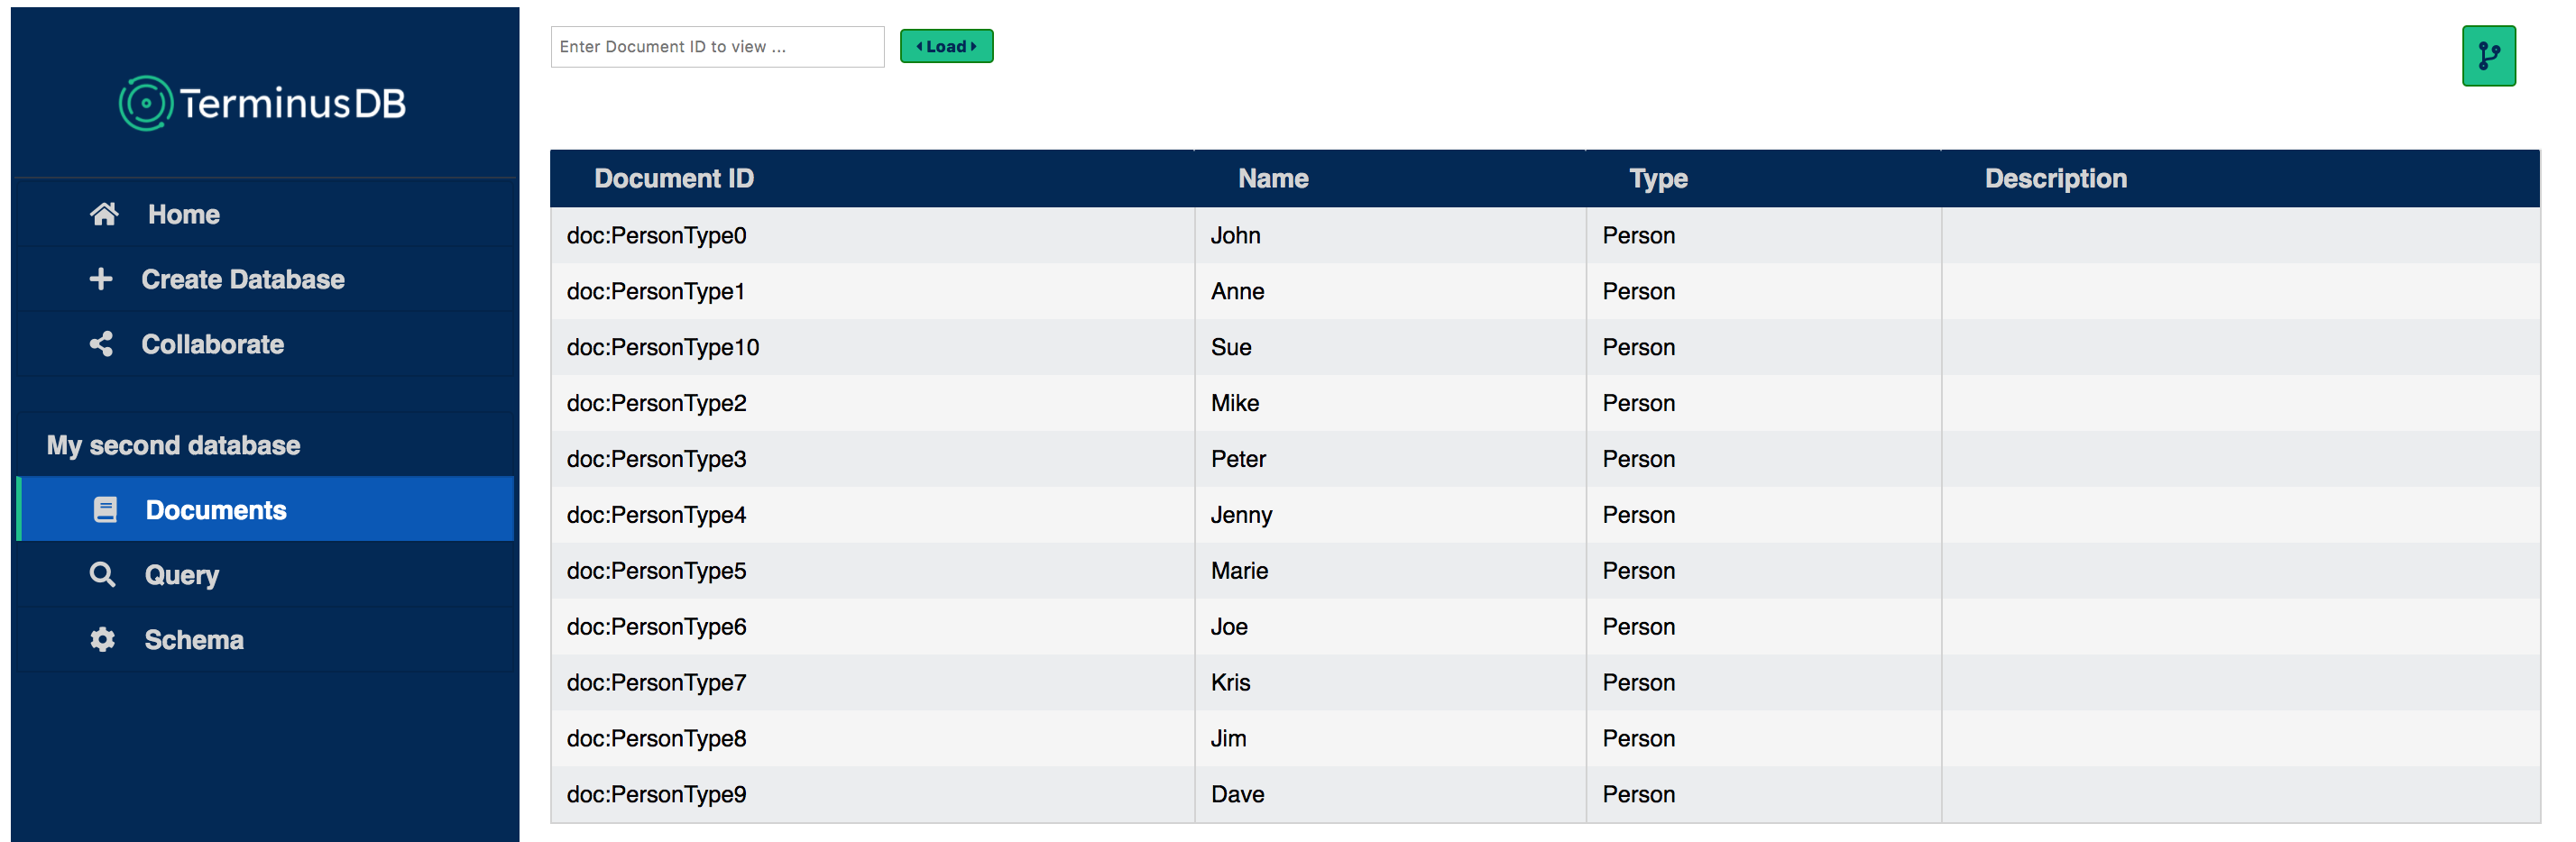

Clicking through any of the documents - for example `Jenny` -- will show: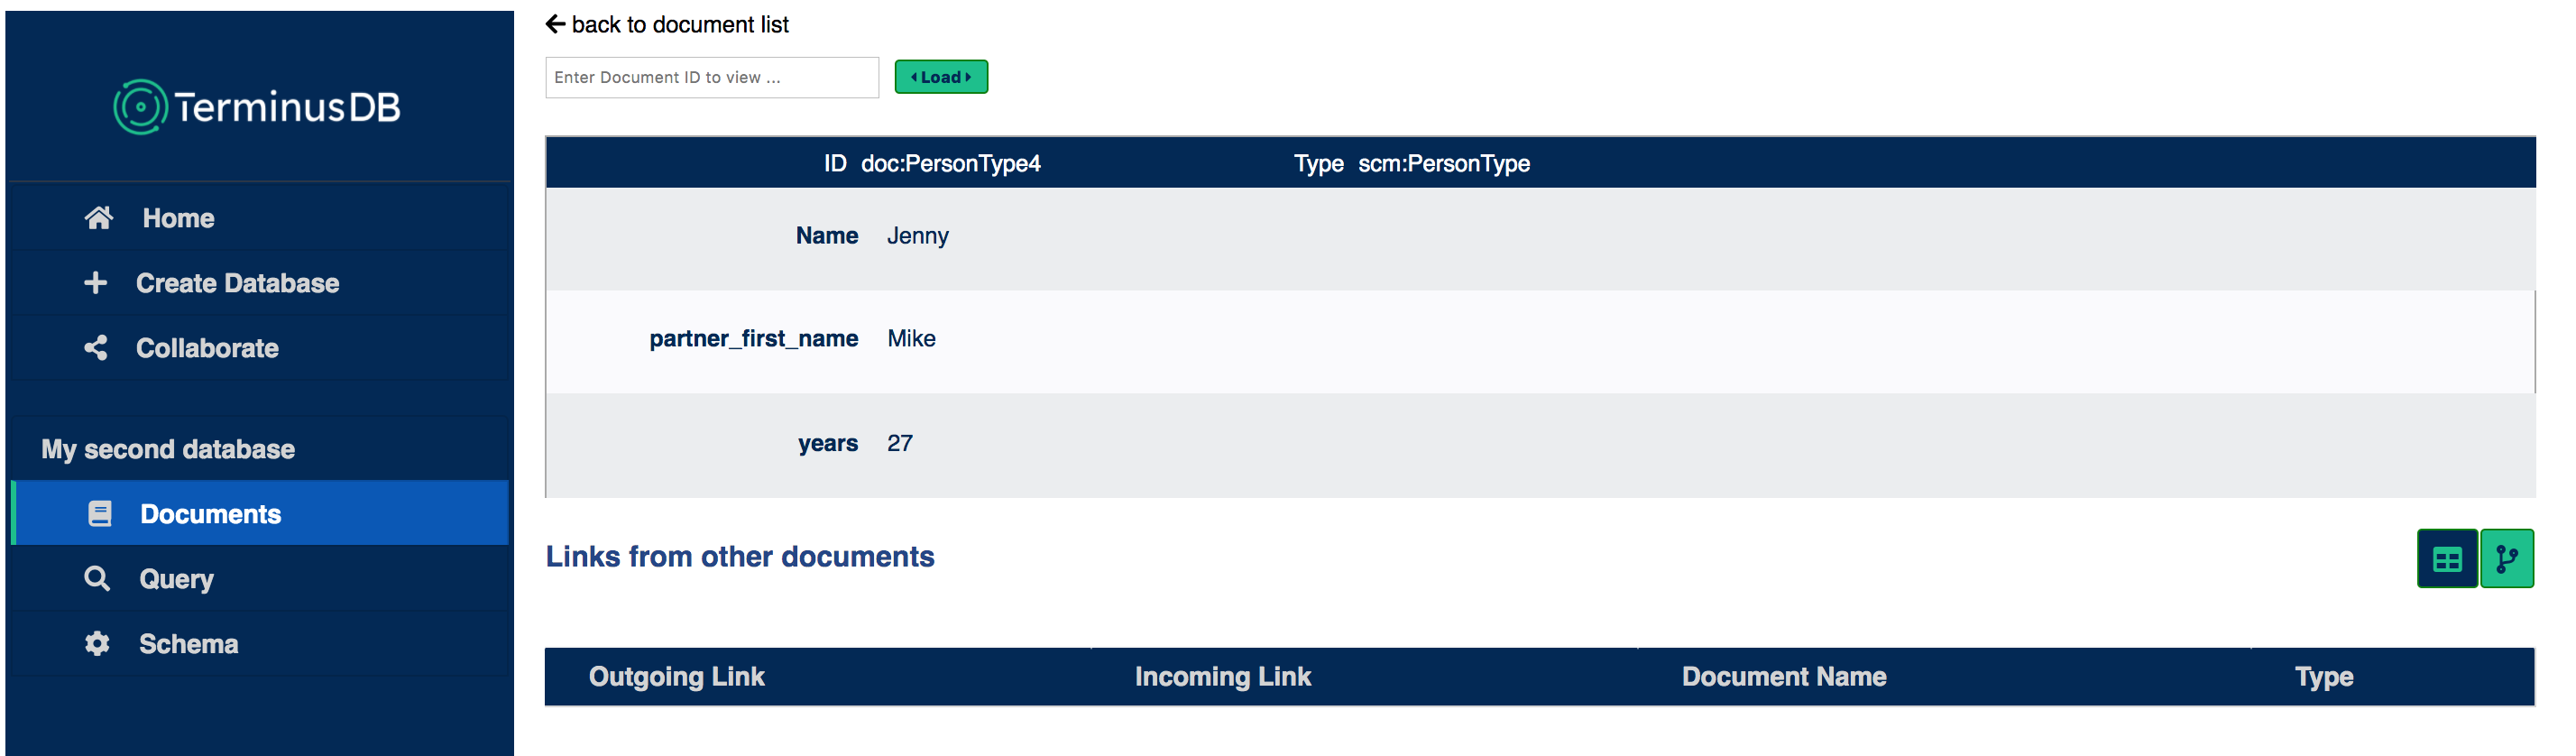

---

# Cleaning up the data
Lets query our database and so ensure all the data appears correct: 

In [62]:
people = WOQLQuery().select("v:Name", "v:Age", "v:Partner").woql_and(
                WOQLQuery().triple("v:PersonID", "label", "v:Name"),
                WOQLQuery().triple("v:PersonID", "Age", "v:Age"),
                WOQLQuery().triple("v:PersonID", "Partner", "v:Partner"),
            )
result = people.execute(client)
df = wdf.query_to_df(result) 
print(df.to_string(index=False))

Sending to URL____________ http://localhost:6363/DB_CSV/woql
sendRequestByAction_____________ woql_update
  Age   Name Partner
 34.0   John   Marie
 26.0   Anne   Peter
 26.0    Sue        
 28.0   Mike   Jenny
 27.0  Peter    Anne
 27.0  Jenny    Mike
 33.0  Marie    John
 34.0    Joe    Kris
 35.0   Kris     Jim
 36.0    Jim    Kris
 34.0   Dave        


We can see that neither Sue nor Dave have partners.  Perhaps we should restrict our database to only people who *do* have partners.  So,  first lets build a query to pick out Sue and Dave.  Their empty `Partner` attribute in fact is represented as an empty string `""` in WOQL. So, we need to find those people whose `Partner` attribute is an empty string.

However (as we noted in the first tutorial), the woqlclient module currently has an error in handling Python values directly,  and so we have to use an `@type` dict to indicate the null string:

In [63]:
no_partners = WOQLQuery().select("v:Name").woql_and(
                WOQLQuery().triple("v:PersonID", "label", "v:Name"),
                
                # would like to do WOQLQuery().triple("v:PersonID", "Partner", ""}) here, but instead...
                WOQLQuery().triple("v:PersonID", "Partner", {'@type': 'xsd:string', '@value': ""}),
            )
result = no_partners.execute(client)
df = wdf.query_to_df(result)
print(df.to_string(index=False))

Sending to URL____________ http://localhost:6363/DB_CSV/woql
sendRequestByAction_____________ woql_update
 Name
  Sue
 Dave


A `when` clause is needed to update and remove those people without partners from the database:

In [64]:
deleteSingles = WOQLQuery().when(
        WOQLQuery().woql_and(
            WOQLQuery().triple("v:PersonID", "label", "v:Name"),
            WOQLQuery().triple("v:PersonID", "Partner", {'@type': 'xsd:string', '@value': ""})
        ),
        WOQLQuery().delete_triple("v:PersonID", "type", "scm:PersonType")
)
result = deleteSingles.execute(client)

Sending to URL____________ http://localhost:6363/DB_CSV/woql
sendRequestByAction_____________ woql_update


Checking the console, we can see that Dave and Sue are now removed: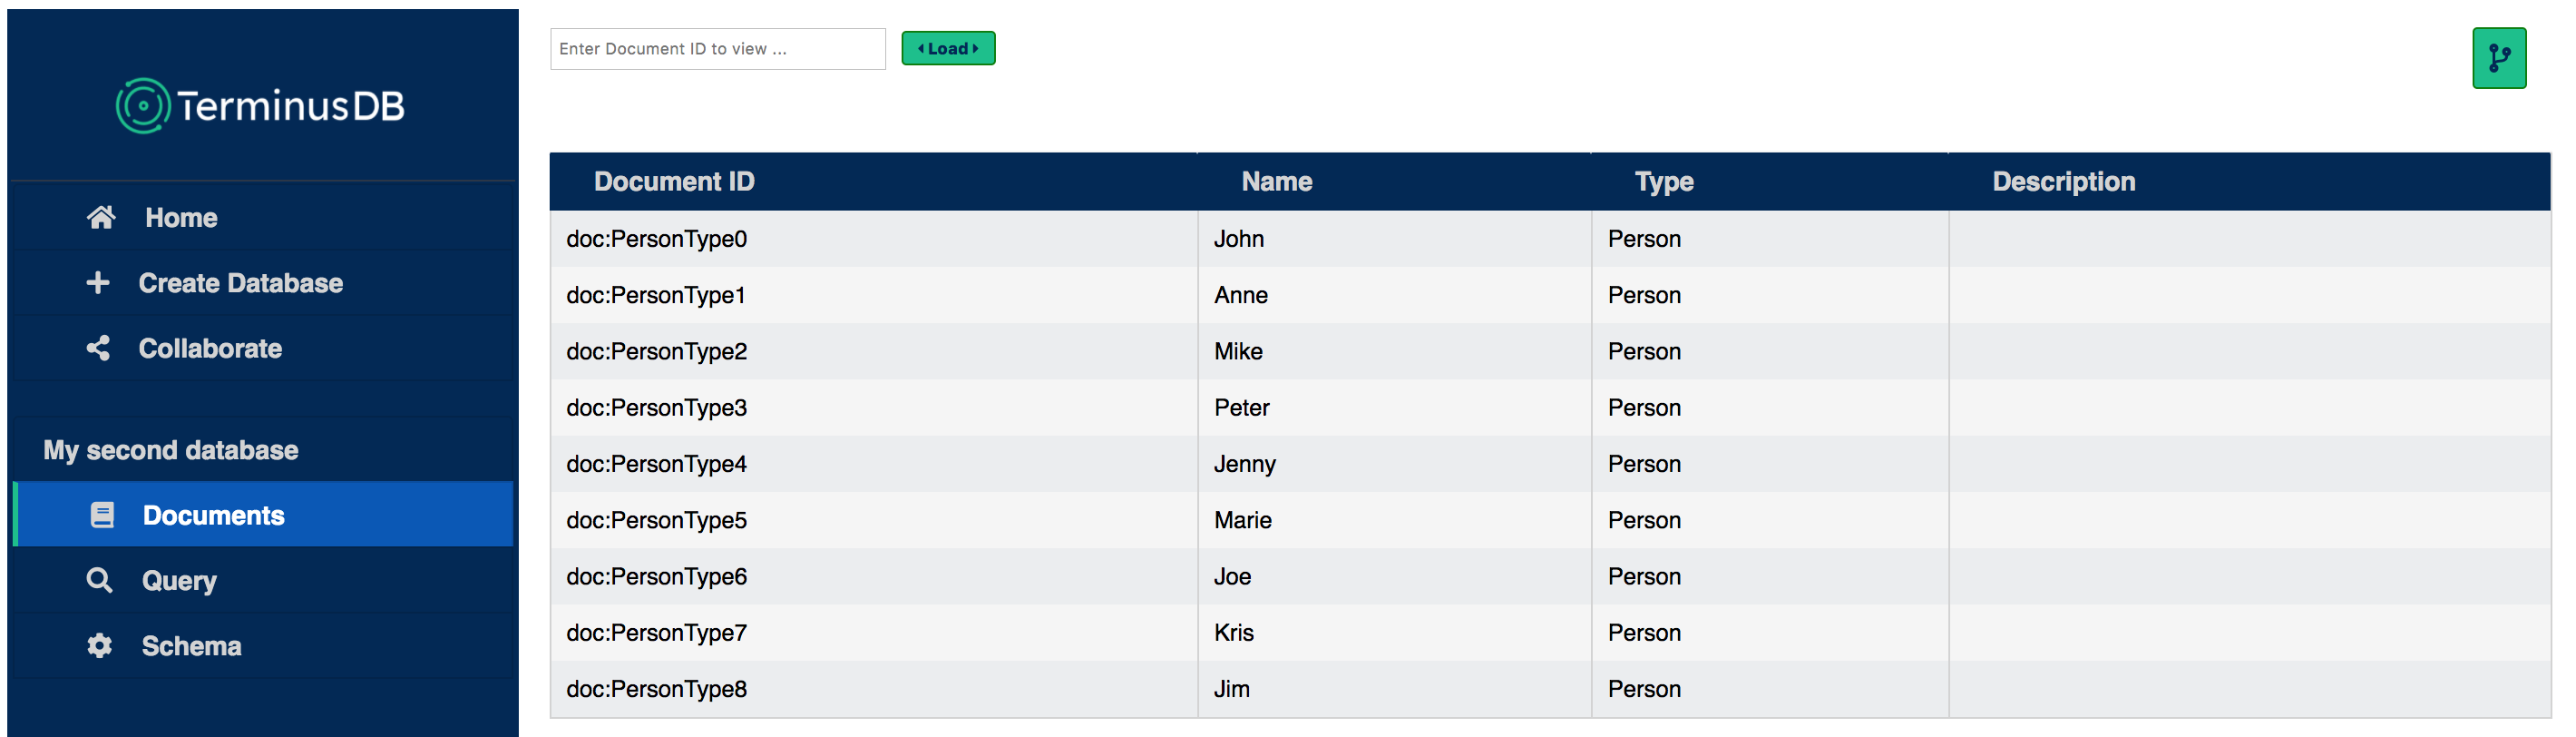


The final clean-up might be to sort out Kris, Jim and Joe. You might remember that Joe claims Kris is his partner, but Jim and Kris claim that they are each others partner.  So Joe isn't in a good place,  and we should remove him.

So, lets build a query which identifies people like Joe: they claim to have a specific partner,  but that partner denies it. We'll select `v:Invalid_Partner` for the names of those people who do not have a valid partner.  Each of these claim to have a `v:Claimed_Partner`, but that person asserts that their `Partner` is not (using `woql_not`) `v:Invalid_Partner`. And so: 

In [65]:
partners = WOQLQuery().select("v:Invalid_Partner").woql_and(
                WOQLQuery().triple("v:PersonID1", "label", "v:Invalid_Partner"),
                WOQLQuery().triple("v:PersonID2", "label", "v:Claimed_Partner"),
                WOQLQuery().triple("v:PersonID1", "Partner", "v:Claimed_Partner"),
                WOQLQuery().woql_not().triple("v:PersonID2", "Partner", "v:Invalid_Partner"),
            )
result = partners.execute(client)
df = wdf.query_to_df(result)
print(df.to_string(index=False))

Sending to URL____________ http://localhost:6363/DB_CSV/woql
sendRequestByAction_____________ woql_update
Invalid_Partner
            Joe


And next, set up a `when` update clause to delete such people from our database:

In [66]:
delete_Exs = WOQLQuery().when(
                WOQLQuery().woql_and(
                    WOQLQuery().triple("v:PersonID1", "label", "v:Invalid_Partner"),
                    WOQLQuery().triple("v:PersonID2", "label", "v:Claimed_Partner"),
                    WOQLQuery().triple("v:PersonID1", "Partner", "v:Claimed_Partner"),
                    WOQLQuery().woql_not().triple("v:PersonID2", "Partner", "v:Invalid_Partner")
                ),
                WOQLQuery().delete_triple("v:PersonID1", "type", "scm:PersonType")
            )
result = delete_Exs.execute(client)

Sending to URL____________ http://localhost:6363/DB_CSV/woql
sendRequestByAction_____________ woql_update


And now Joe has gone from the database (he was at position 6:)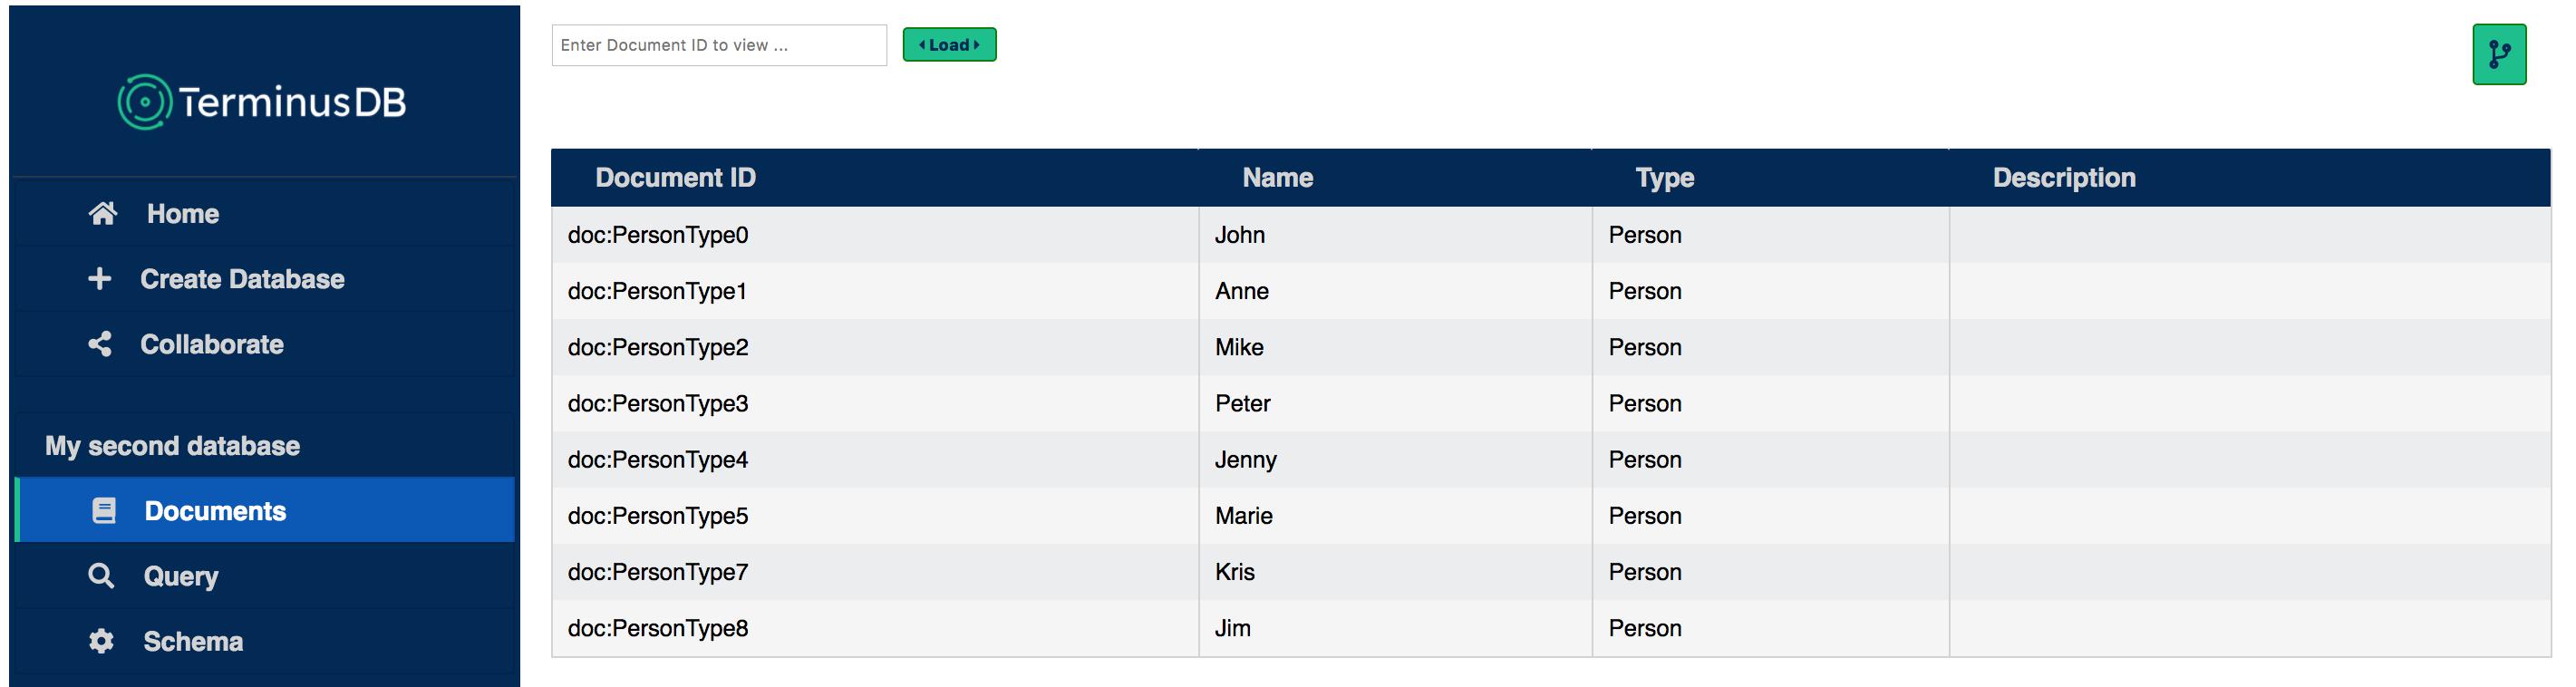


---

# To Come
Further things for which it would be good to write up a tutorial like this:
* Building documents with relationships between them
* Building class hierarchies..